In [84]:
import os
import pickle
import numpy as np
from itertools import permutations
import pandas as pd
import pingouin as pg

# statistical methods
from scipy.stats import chisquare
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

from bioinfokit.analys import stat

import statsmodels.stats as st
from statsmodels.graphics.factorplots import interaction_plot

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# read all the backups
address = "../data/equicity_kabeldistrict/backup"
game_backups = os.listdir(address)
#game_backups.pop(game_backups.index('.DS_Store'))
# sort the folders in ascending order
game_backups.sort()

In [3]:
game_id = -1
# load project and users dict
project_dict = pickle.load( open( address + "/" + game_backups[game_id] + "/project.pickle", "rb" ) )
users_dict = pickle.load( open( address + "/" + game_backups[game_id] + "/users.pickle", "rb" ) )
problem_dict = pickle.load( open("../data/problem.pickle", "rb" ) )

In [8]:
def print_keys(d, l=0):
    # iterate over the dict keys
    for k in d.keys():
        # extract the shape if the value is a list
        shape = np.array(d[k]).shape if isinstance(d[k],list) else ""
        # print info
        print(l*"  ", k, ":", type(d[k]), shape)
        # recurse if the value is a dict
        if isinstance(d[k],dict):
            print_keys(d[k], l+1)

# print_keys(project_dict)

## Analysis Outline

### Questions!

1. are the site and actor homogenous:
    * 1.1. how homogenous are the decisions of the participants (considering that the roles are different)?
    * 1.2. how homogeneously the sites are being treated by the decisions of the participants (considering that they have different potentials)? (this will be assessed by the type of allocation/investment that is being proposed for each of them)
2. how different are the decisions of the participants from round to round?
3. are the players improving their scores through the game play (generally)? (for this question also we can combine the info from all the games)
4. will longer discussion times result in larger change in their decision or their score?
    * for this question the result of all workshops can be combined together

### Considerations

* 1st question: the two sub questions can be combined as a two level [ANOVA](https://en.wikipedia.org/wiki/Analysis_of_variance), and the participants and sites will be the main effect and their intersection will be the interaction/cross-effect
* 2nd question: since the main format of the data is not vectors but matrices, we need to unroll the matrices into one dimensional arrays, for that we need [Quadratic Assignment Process](https://ideas.repec.org/p/boc/asug01/1.2.html). So first we need to permute (changing the order of rows and columns) randomly for 1K variations, and then we need to unroll these matrices in the same way, and run the statistical analysis, which will result in a distribution of statistics, and then the p value can be estimated. 
* in statistics we have to be wary of false positive and false negatives, by repeating the test several times, we would increase the chance of falling into false positive, this is more relevant to change of scores (question 3, 4), yet since we are performing this for multiple tests already, it means that we need to adjust the p-value, which is called [bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) or another correction in the same family
* for the chi-square, if we are performing multiple times (multiple means for different rounds, different participants, and sites), then the collective test needs to be executed first ([ANOVA](https://en.wikipedia.org/wiki/Analysis_of_variance) family such as H test), then only if this significant then we perform the post-hoc individual test
* regarding the methods, we are only 100% sure about the chi-square and the pearsman, the rest need to be checked

### Methods

* 1 and 2:
    * (individual, based on each round) since it is categorical data, [chi-square](https://en.wikipedia.org/wiki/Chi-squared_test), with the assumption that the next round is expected, and this round is the observed set, so we can measure the dif (this is probably the most relevant)
    * [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann–Whitney_U_test) is similar to chi-square (chi-square is potentially better since U test is related to ordinal data)
    * (overall) [Kruskal-Wallis H tests](https://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance), a kind of an analysis of variance, it is to compare different groups of U test (this is also can be checked to see if it can extend chi-square (it normally extents the U test))

* 3:
    * measure the positive change of every round for each score separately, and perform a [t test](https://en.wikipedia.org/wiki/Student%27s_t-test) and compare the distribution to zero, since we want to know if it is significantly changing, 
    * the hypothesis is that whether the change is larger than zero
    
* 4:
    * for assessing the change in the scores since they are numerical, it is just a correlation: [pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), (or [spearman](https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php))
    * for the changes in the decision, since they are categorical, an approach to assess the change in the categorical data, we can use [earth movers distance](https://en.wikipedia.org/wiki/Earth_mover%27s_distance) (check if this can be used to assess the first question)

### Sources to study statistics
* statistical methods for geography, peter rogerson
* spatial statistics for geography, peter rogerson

* they use SPSS, but scipy is sufficient to replace that

## Analysis Implementation

### Q1
**are the site and actor homogenous with respect to decisions?**

In [11]:
# extract the decision dictionary
decision_dict = project_dict["gameplay"]["X"]
# remove the 0 time stamp
_ = decision_dict.pop("0", None)
# extract and sort time stamps of decisions
dec_ts_sorted = np.array(list(decision_dict.keys()), dtype=int)
dec_ts_sorted.sort()
# extract a sample decision
x0 = np.array(decision_dict[str(dec_ts_sorted[0])]) * 1.05 - 0.01
# construct a 4 dimensional tensor containting all the observations:
# (Rounds, Actors, Sites, Colors)
X = np.array([decision_dict[str(ts)] for ts in dec_ts_sorted]) * 1.05 - 0.01

In [30]:
# Average over the color dimension: average color allocation per site, per actor for each round
# after averaging, the dimension corresponding is collapsed (due to aggregation), ...
# so to make the tensor comarable with the original tensor, we add an empty dimension in place of the color dimension
X_C_mean = X.mean(axis=3)[:, :, :,np.newaxis]

In [31]:
# subtracting the X-average-color from the X to emphasise that a decision fro a color bellow average is effectively a decision against allocation of space to that color
X_tilda = X - X_C_mean 

In [39]:
# extract the decision dictionary
pooled_decision_dict = project_dict["gameplay"]["D"]
# remove the 0 time stamp
_ = pooled_decision_dict.pop("0", None)
# extract and sort time stamps of decisions
pdec_ts_sorted = np.array(list(pooled_decision_dict.keys()), dtype=int)
pdec_ts_sorted.sort()
# construct a 3 dimensional tensor containting all the pooled decisions:
# (Rounds, Sites, Colors)
D = np.array([pooled_decision_dict[str(ts)] for ts in pdec_ts_sorted])

(3, 7, 5)

In [45]:
# extract the decision dictionary
fitted_decision_dict = project_dict["gameplay"]["V"]
# remove the 0 time stamp
_ = fitted_decision_dict.pop("0", None)
# extract and sort time stamps of decisions
fdec_ts_sorted = np.array(list(fitted_decision_dict.keys()), dtype=int)
fdec_ts_sorted.sort()
# construct a 3 dimensional tensor containting all the pooled decisions:
# (Rounds, Sites, Colors)
V = np.array([fitted_decision_dict[str(ts)] for ts in fdec_ts_sorted])

In [70]:
plt.rcParams['figure.figsize'] = [10,10]

In [135]:
def plot_matrix(ax, matrix, cmap, title_text, decimals=2):
    ax.matshow(matrix, cmap=cmap)
    ax.set_title(title_text, color="black")
    ax.tick_params(color="black", labelcolor="black")

    for spine in ax.spines.values():
        spine.set_edgecolor("black")
    x, y = np.indices(matrix.shape)
    for i, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
        c = str(np.round(matrix[x_val, y_val], decimals))
        ax.text(y_val, x_val, c, va='center', ha='center', color="black")

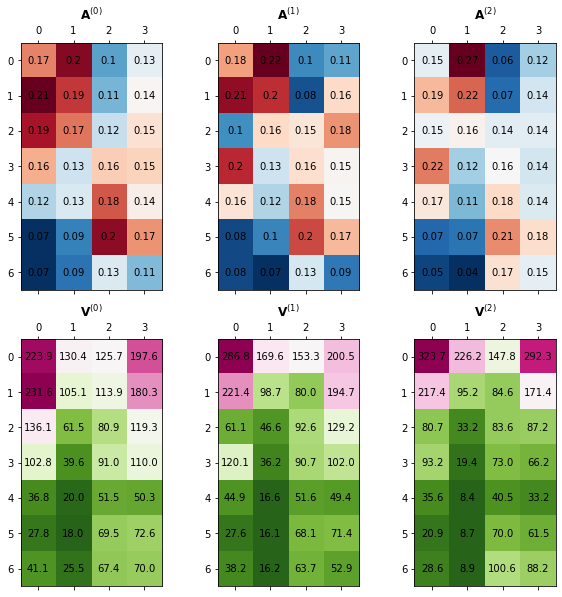

In [136]:
fig, ax = plt.subplots(2, 3)
fig.set_facecolor((1,1,1,1))

plot_matrix(ax[0,0], D[0,:, :-1], "RdBu_r", r"$\mathbf{A}^{(0)}$", 2)
plot_matrix(ax[0,1], D[1,:, :-1], "RdBu_r", r"$\mathbf{A}^{(1)}$", 2)
plot_matrix(ax[0,2], D[2,:, :-1], "RdBu_r", r"$\mathbf{A}^{(2)}$", 2)
plot_matrix(ax[1,0], V[0,:, :-1], "PiYG_r", r"$\mathbf{V}^{(0)}$", 1)
plot_matrix(ax[1,1], V[1,:, :-1], "PiYG_r", r"$\mathbf{V}^{(1)}$", 1)
plot_matrix(ax[1,2], V[2,:, :-1], "PiYG_r", r"$\mathbf{V}^{(2)}$", 1)

fig.savefig("../out/Tensor_Plots_A_V_per_Round.pdf")
fig.savefig("../out/Tensor_Plots_A_V_per_Round.png", dpi=600, )

In [115]:
y

array([[0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3]])

array([[[0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4],
        [5, 5, 5, 5],
        [6, 6, 6, 6]],

       [[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]]])

In [95]:
D[0,:, :-1]

array([[0.17175812, 0.1995773 , 0.10389263, 0.13345854],
       [0.2050487 , 0.18563462, 0.10860706, 0.14051213],
       [0.19354146, 0.17432917, 0.12387763, 0.14937927],
       [0.16327157, 0.12538258, 0.15567762, 0.15383611],
       [0.11947936, 0.12934497, 0.18006131, 0.14373054],
       [0.0734504 , 0.09484688, 0.1979988 , 0.16886361],
       [0.0734504 , 0.09088449, 0.12988495, 0.11021979]])

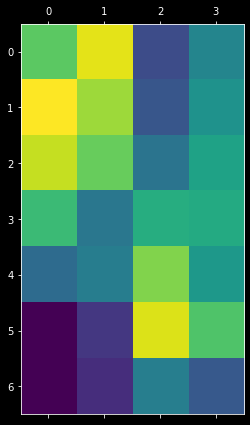

In [54]:
plt.matshow(D[0,:, :-1])
plt.show()

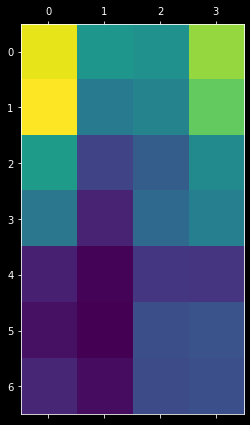

In [50]:
plt.matshow(V[0, :, :-1])

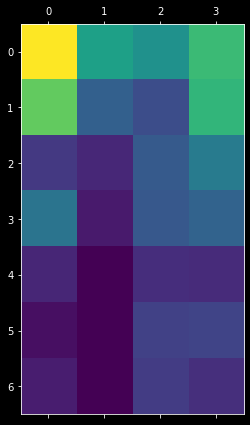

In [53]:
plt.matshow(V[1, :, :-1])

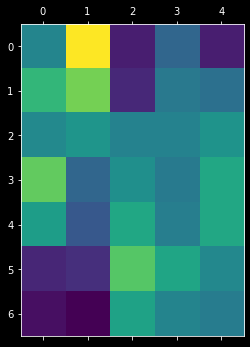

In [44]:
plt.matshow(D[2])

In [28]:
# extract the max area of each site and bring it to the right shape
site_max_area_toshape = problem_dict['site_max_area'].reshape(1,1,-1,1)
# multiply X by the max area size to make decision variables comparable accross sites
X *= site_max_area_toshape

#### Q1.1
**how homogenous are the decisions of the participants (considering that the roles are different)?**

In [29]:
# transpose the X (decision tensor) to the following shape:
# (Actor, Site, Color, Round)
X_A = X.transpose(1,2,3,0)
# flatten all the dimensions except the actor dimension
X_a = X_A.reshape((X_A.shape[0], -1))

In [30]:
# H0: there is no significant difference between the decisions of different players
# H1: there is a significant difference between the decision of the players
# alpha: 0.05
ALPHA = 5e-2
# number of decision entries (decision variables)
n = X_a.shape[1]
# number of observations in total
N = X_a.size
# degrees of freedom
df_between =  N//n - 1
df_within = N - N//n
df_total = N - 1 # : df_between + df_within
(df_between, df_within)

(4, 520)

In [31]:
r = f_oneway(*tuple(X_a))
print("statistic :", r.statistic)
print("p-value :", r.pvalue)
print("H0 is", ALPHA < r.pvalue, "and H1 is", ALPHA > r.pvalue)

statistic : 2.6879755484275603e-31
p-value : 1.0
H0 is True and H1 is False


#### Q1.2
**how homogeneously the sites are being treated by the decisions of the participants (considering that they have different potentials)?**

In [32]:
# transpose the X (decision tensor) to the following shape:
# (Site, Actor, Color, Round)
X_S = X.transpose(2,1,3,0)
# flatten all the dimensions except the actor dimension
X_s = X_S.reshape((X_S.shape[0], -1))

In [33]:
# H0: there is no significant difference between the decisions about different sites
# H1: there is a significant difference between the decision about sites
# alpha: 0.05
ALPHA = 5e-2
# number of decision entries (decision variables)
n = X_s.shape[1]
# number of observations in total
N = X_s.size
# degrees of freedom
df_between =  N//n - 1
df_within = N - N//n
df_total = N - 1 # : df_between + df_within
(df_between, df_within)

(6, 518)

In [34]:
r = f_oneway(*tuple(X_s))
print("statistic :", r.statistic)
print("p-value :", r.pvalue)
print("H0 is", ALPHA < r.pvalue, "and H1 is", ALPHA > r.pvalue)

statistic : 27.72011778236314
p-value : 9.806421638120218e-29
H0 is False and H1 is True


#### Q1 
(sub-questions combined using two-way ANOVA)

In [35]:
# convert the X to pandas dataframe
X_ind = np.indices(X.shape)
X_ind_flat = X_ind.reshape(X_ind.shape[0], -1)
X_df = pd.DataFrame(X_ind_flat.T, columns=["Round", "Actor", "Site", "Color"])
X_df["x"] = X.ravel()
X_df

,Round,Actor,Site,Color,x
0,0,0,0,0,9.447619
1,0,0,0,1,24.209524
2,0,0,0,2,12.400000
3,0,0,0,3,12.400000
4,0,0,0,4,3.542857
...,...,...,...,...,...
520,2,4,6,0,4.114286
521,2,4,6,1,2.828571
522,2,4,6,2,10.542857
523,2,4,6,3,6.685714


##### Descriptive Statistics of the three levels for Actor, Site, and Color

In [36]:
X_df[['Actor','x']].groupby('Actor').mean(), X_df[['Actor','x']].groupby('Actor').std()

(               x
 Actor           
 0      12.857143
 1      12.857143
 2      12.857143
 3      12.857143
 4      12.857143,
                x
 Actor           
 0       5.620331
 1      10.812744
 2       9.928387
 3       9.595742
 4       6.064346)

In [37]:
X_df[['Site','x']].groupby('Site').mean(), X_df[['Site','x']].groupby('Site').std()

(         x
 Site      
 0     12.4
 1     11.8
 2     17.8
 3     17.8
 4      9.2
 5     15.6
 6      5.4,
               x
 Site           
 0      8.696090
 1      6.881900
 2     10.474277
 3      5.993572
 4      4.105909
 5      9.098105
 6      5.628164)

In [42]:
X_df[['Site','x']].groupby('Site').mean().to_numpy().flatten()  / site_max_area_toshape.flatten()

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

In [18]:
X_df[['Color','x']].groupby('Color').mean(), X_df[['Color','x']].groupby('Color').std()

(               x
 Color           
 0       9.430385
 1      12.918821
 2      14.351474
 3      15.555556
 4      12.029478,
               x
 Color          
 0      7.217390
 1      9.436153
 2      8.989219
 3      8.246965
 4      7.988980)

##### Checking for Assumptions of ANOVA

First check for the homogeneity of the data for equal variance

In [19]:
res = stat()
res.levene(df=X_df, res_var='x', xfac_var=['Actor','Site','Color'])
res.levene_summary

,Parameter,Value
0,Test statistics (W),0.7688
1,Degrees of freedom (Df),174.0000
2,p value,0.9748


The dataset with three-way design has equal variance with Levene test (*W*=.797, *df*=174, *p*=0.954). Normal ANOVA is used for later comparison.

##### ANOVA

In [60]:
# three-way ANOVA usign Pingouin library
aov = pg.anova(data=X_df, dv='x', between=['Actor', 'Site', 'Color'], detailed=True,effsize='np2').round(3)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Actor,0.000,4.0,0.000,0.000,1.0,0.000
1,Site,0.000,6.0,0.000,0.000,1.0,0.000
2,Color,0.604,4.0,0.151,42.276,0.0,0.326
3,Actor * Site,0.000,24.0,0.000,0.000,1.0,0.000
4,Actor * Color,2.834,16.0,0.177,49.596,0.0,0.694
5,Site * Color,1.180,24.0,0.049,13.762,0.0,0.486
6,Actor * Site * Color,2.766,96.0,0.029,8.068,0.0,0.689
7,Residual,1.250,350.0,0.004,NaN,NaN,NaN


The three-way ANOVA shows that the main effects of Actor and Site are not significant: *F*<sub>a</sub>(4,350)=0, *p*>.05,$\eta^2$=0; *F*<sub>s</sub>(6,350)=0, *p*>.05,$\eta^2$=0; the main effect of Color is significant: *F*<sub>c</sub>(4,350)=42.276, *p*<.001,$\eta^2$=.326. The interaction effect between color and both actor and site are significant: *F*<sub>a\*c</sub>(16,350)=49.596, *p*<0.001,$\eta^2$=.694; *F*<sub>a\*s</sub>(24,350)=13.762, *p*<0.001,$\eta^2$=.486. And the 3-way interaction effect among actor, site, and color is significant: *F*<sub>a\*c\*s</sub>(96,350)=8.068, *p*<0.001,$\eta^2$=.689.

##### Post-hoc analysis using Tukey-HSD test

In [62]:
X_df.pairwise_tukey(dv='x', between='Color').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,0,1,0.141,0.194,-0.052,0.017,-3.041,0.021,-0.418
1,0,2,0.141,0.228,-0.086,0.017,-5.024,0.000,-0.691
2,0,3,0.141,0.239,-0.098,0.017,-5.685,0.000,-0.782
3,0,4,0.141,0.198,-0.057,0.017,-3.305,0.009,-0.455
4,1,2,0.194,0.228,-0.034,0.017,-1.983,0.276,-0.273
5,1,3,0.194,0.239,-0.045,0.017,-2.644,0.064,-0.364
6,1,4,0.194,0.198,-0.005,0.017,-0.264,0.999,-0.036
7,2,3,0.228,0.239,-0.011,0.017,-0.661,0.965,-0.091
8,2,4,0.228,0.198,0.029,0.017,1.719,0.423,0.236
9,3,4,0.239,0.198,0.041,0.017,2.380,0.122,0.327


The post-hoc analyses on the main effect of color show that colors 1-4 have significantly higher proportion than color 0, *p*<.05 while the other differences are non-significant.

##### Plotting the interaction effects

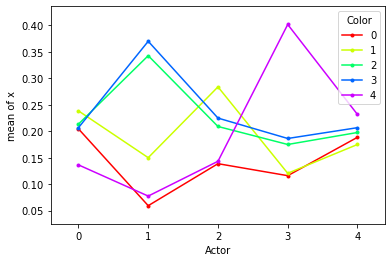

In [74]:
fig = interaction_plot(X_df['Actor'],X_df['Color'],X_df['x'])
plt.show()

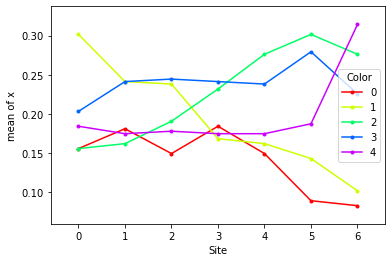

In [75]:
fig = interaction_plot(X_df['Site'],X_df['Color'],X_df['x'])
plt.show()

The interaction patterns of color-actor and color-site shows that different colors are distributed by different actors and on different sites unequally, proving that the sites and actors are not homogeneously acting during the game.

### Q2
**how different are the  decisions of the participants from round to round?**

Since the Q2 is also similar to the questions of Q1, I have integrated them into a three-way ANOVA.

In [85]:
# three-way ANOVA usign Pingouin library
aov = pg.anova(data=X_df, dv='x', between=['Actor', 'Site', 'Round'], detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Actor,1.019538e-30,4.0,2.548846e-31,1.239751e-29,1.0,1.180715e-31
1,Site,2.228155e-31,6.0,3.713592e-32,1.806280e-30,1.0,2.580401e-32
2,Round,7.358383e-31,2.0,3.679192e-31,1.789548e-29,1.0,8.521657e-32
3,Actor * Site,4.077713e-30,24.0,1.699047e-31,8.264114e-30,1.0,4.722351e-31
4,Actor * Round,7.628112e-30,8.0,9.535140e-31,4.637864e-29,1.0,8.834027e-31
5,Site * Round,1.349223e-30,12.0,1.124353e-31,5.468818e-30,1.0,1.562519e-31
6,Actor * Site * Round,3.248801e-30,48.0,6.768336e-32,3.292099e-30,1.0,3.762398e-31
7,Residual,8.634921e+00,420.0,2.055933e-02,NaN,NaN,NaN


##### Descriptive Statistics of the Rounds

In [77]:
X_df[['Round','x']].groupby('Round').mean(), X_df[['Round','x']].groupby('Round').std()

(         x
 Round     
 0      0.2
 1      0.2
 2      0.2,
               x
 Round          
 0      0.117644
 1      0.135843
 2      0.131653)

##### Checking for Assumptions of ANOVA

First check for the homogeneity of the data for equal variance

In [78]:
res = stat()
res.levene(df=X_df, res_var='x', xfac_var=['Round','Color'])
res.levene_summary

,Parameter,Value
0,Test statistics (W),0.9669
1,Degrees of freedom (Df),14.0000
2,p value,0.4863


The dataset with two-way design of round-color has equal variance with Levene test (*W*=.9669, *df*=14, *p*=0.486). Normal ANOVA is used for later comparison.

##### ANOVA

In [83]:
# three-way ANOVA usign Pingouin library
aov = pg.anova(data=X_df, dv='x', between=['Round', 'Color'], detailed=True, effsize='np2').round(3)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Round,0.000,2,0.000,0.000,1.000,0.000
1,Color,0.604,4,0.151,9.728,0.000,0.071
2,Round * Color,0.114,8,0.014,0.922,0.498,0.014
3,Residual,7.916,510,0.016,NaN,NaN,NaN


The two-way ANOVA shows that the main effects of Round is not significant: *F*<sub>r</sub>(2,510)=0, *p*>.05,$\eta^2$=0; the main effect of Color is significant: *F*<sub>c</sub>(4,510)=9.728, *p*<.001,$\eta^2$=.071. The interaction effect between color and round is not significant: *F*<sub>a\*r</sub>(8,510)=0.922, *p*>.05,$\eta^2$=.014.

##### Plotting the interaction effects

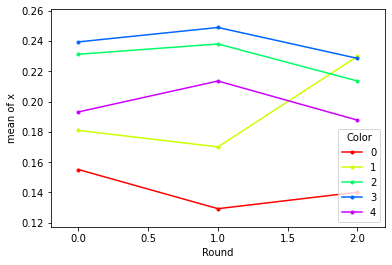

In [86]:
fig = interaction_plot(X_df['Round'],X_df['Color'],X_df['x'])
plt.show()

The interaction patterns of color-round shows that different colors are distributed equally for each round, showing that no significant changes have occured along the game-play.

### Q3
**are the players improving their scores through the game play (generally)?**

In [63]:
# extract the scores
score_dict = project_dict["game_info"]["scores"]
# remove the recent scores
[score_dict.pop(k, None) for k in ['change_score_t',  'closeness_score_t', 'environmental_score_t', 'individual_score_t']]
# extract individual scores
indiv_score = score_dict.pop("individual_score", None)
# separate valid scores
valid_scores = {}
for k, v in indiv_score.items():
    if isinstance(v, dict):
        valid_scores[k[:5]] = v
# update the score dictionary with the calid scores
score_dict.update(valid_scores)

In [64]:
unified_score_dict = {}
# simplify the timestamps to unify
for k, v in score_dict.items():
    local_score_dict = {}
    for k0, v0 in v.items():
        local_score_dict[str(int(int(k0)*1.e-5))] = v0
    unified_score_dict[k] = local_score_dict

In [65]:
# convert the data dictionary 
scores_df = pd.DataFrame(unified_score_dict).drop("0")
scores_df

,change_score,closeness_score,environmental_score,2rH45,9gDju,Ccmr7,LNYUh,gHqMt
16383670,0.679600,0.314523,0.850648,0.172787,0.284601,0.330133,0.418206,0.347863
16383681,0.678689,0.308280,0.850327,0.171625,0.285477,0.329160,0.417075,0.347863
16383706,0.655034,0.299094,0.824199,0.166619,0.286388,0.325213,0.408819,0.347863


In [19]:
# iterate over the rounds
for i in range(len(scores_df) - 1):
    # extract the scores of the rounds
    s0 = scores_df.iloc[i].to_numpy()
    s1 = scores_df.iloc[i+1].to_numpy()
    # run the t test
    obs = ttest_1samp(s1 - s0 , 0)
    print("round :", i)
    print("statistic :", obs.statistic)
    print("p-value :", obs.pvalue)

round : 0
statistic : -1.6288181349765882
p-value : 0.14737518610312203
round : 1
statistic : -2.609286812560844
p-value : 0.034949586466993886


#### Q4
**will longer discussion times result in larger change in their decision or their score?**

In [66]:
# extract the index as time
scores_df["time"] = scores_df.index
# convert the type from string to int
scores_df = scores_df.astype({'time': 'int'})
# compute the difference between rounds of the game
scores_diff = scores_df.diff()
# drop the NaN row
scores_diff = scores_diff.dropna()

In [67]:
scores_diff

,change_score,closeness_score,environmental_score,2rH45,9gDju,Ccmr7,LNYUh,gHqMt,time
16383681,-0.000911,-0.006243,-0.000321,-0.001162,0.000876,-0.000973,-0.001131,-1.110223e-16,11.0
16383706,-0.023656,-0.009186,-0.026128,-0.005006,0.000911,-0.003947,-0.008256,0.000000e+00,25.0


In [21]:
# compute the pearson correlation
scores_diff.corr()

,change_score,closeness_score,environmental_score,2rH45,9gDju,Ccmr7,LNYUh,gHqMt,time
change_score,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0
closeness_score,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0
environmental_score,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0
2rH45,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0
9gDju,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0
Ccmr7,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0
LNYUh,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0
gHqMt,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0
time,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0
